2026-02-17 20:04:05.813 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-17 20:04:05.813 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-17 20:04:05.870 
  command:

    streamlit run /Users/sun/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]
2026-02-17 20:04:05.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-17 20:04:05.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-17 20:04:05.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-17 20:04:05.870 Thread 'MainThread': missing ScriptRunContext! This warning can be igno

DeltaGenerator()

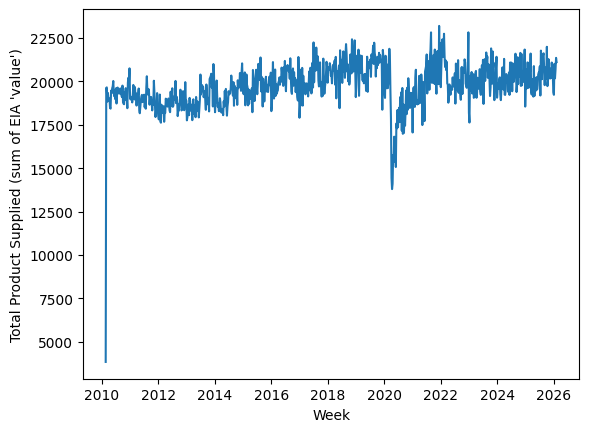

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import streamlit as st

st.set_page_config(page_title="Weekly U.S. Petroleum Supply", layout="wide")
st.title("The Corelation between Weekly U.S. Petroleum Product Supplied and WTI Crude Oil Price")
st.caption("Source: U.S. Energy Information Administration")

# -----------------------------
# API Key (no interaction)
# -----------------------------
# Recommended: set in Streamlit Secrets.
# Create: .streamlit/secrets.toml
# with:   EIA_API_KEY = "YOUR_KEY"
EIA_API_KEY = st.secrets.get("EIA_API_KEY", "")

# For quick local testing ONLY, you can temporarily hardcode:
# EIA_API_KEY = "YOUR_KEY"

if not EIA_API_KEY:
    st.error("Missing EIA API key. Set it in Streamlit Secrets as EIA_API_KEY.")
    st.stop()


# -----------------------------
# Load data
# -----------------------------
@st.cache_data
def load_wpsup_all(api_key: str) -> pd.DataFrame:
    url = (
        "https://api.eia.gov/v2/petroleum/cons/wpsup/data/"
        f"?api_key={api_key}"
        "&frequency=weekly"
        "&data[0]=value"
        "&sort[0][column]=period"
        "&sort[0][direction]=desc"
        "&offset=0"
        "&length=5000"
    )
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    js = r.json()
    data = js.get("response", {}).get("data", [])
    return pd.DataFrame(data)


df = load_wpsup_all(EIA_API_KEY)

if df.empty:
    st.error("No data returned from EIA. Check your API key or endpoint.")
    st.stop()

# -----------------------------
# Clean + aggregate
# -----------------------------
df["period"] = pd.to_datetime(df["period"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df = df.dropna(subset=["period", "value"])

# Standardize week to "week ending Friday" (stable weekly key)
df["week"] = df["period"].dt.to_period("W-FRI").dt.end_time.dt.normalize()

# Total across ALL products per week
weekly_total = (
    df.groupby("week", as_index=False)["value"]
    .sum()
    .rename(columns={"value": "total_product_supplied"})
    .sort_values("week")
)

# Latest week snapshot: top products by value
latest_week = df["week"].max()
latest_snapshot = df[df["week"] == latest_week].copy()

# Some EIA rows include product-name; fallback if missing
name_col = "product-name" if "product-name" in latest_snapshot.columns else None
if name_col:
    latest_by_product = (
        latest_snapshot.groupby(name_col, as_index=False)["value"]
        .sum()
        .sort_values("value", ascending=False)
        .head(10)
    )
else:
    # If no product-name column exists, use product code instead
    latest_by_product = (
        latest_snapshot.groupby("product", as_index=False)["value"]
        .sum()
        .sort_values("value", ascending=False)
        .head(10)
    )

# -----------------------------
# Metrics (static)
# -----------------------------
c1, c2 = st.columns(2)
c1.metric("Weeks in dataset", f"{weekly_total.shape[0]:,}")
c2.metric(
    "Latest total (sum of products)",
    f"{weekly_total['total_product_supplied'].iloc[-1]:,.0f}",
)

st.markdown("---")

# -----------------------------
# Visualization 1: weekly total line
# -----------------------------
st.subheader("Total Product Supplied (Weekly, All Products Summed)")

fig1, ax1 = plt.subplots()
ax1.plot(weekly_total["week"], weekly_total["total_product_supplied"])
ax1.set_xlabel("Week")
ax1.set_ylabel("Total Product Supplied (sum of EIA 'value')")
st.pyplot(fig1)

st.markdown("---")

# -----------------------------


st.caption(
    "Note: 'Product supplied' is often used as a proxy for consumption. "
    "This visualization is descriptive (not causal)."
)